In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2  # Standard TensorFlow Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import json

In [2]:
# Dataset Paths (Update these)
train_dir = r"C:\vitamin_project\dataset\vitamin_project_dataset"
test_dir = r"C:\vitamin_project\dataset\vitamin_project_dataset"
val_dir= r"C:\vitamin_project\dataset\vitamin_project_dataset"
img_size = 224
batch_size = 32
num_classes = len(os.listdir(train_dir))  # Assuming each folder is a class

In [3]:
# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest'
)

# No augmentation for validation and test sets (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(img_size, img_size), batch_size=batch_size,
    class_mode='categorical'
)
validation_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(img_size, img_size), batch_size=batch_size,
    class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(img_size, img_size), batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

Found 13094 images belonging to 11 classes.
Found 13094 images belonging to 11 classes.
Found 13094 images belonging to 11 classes.


In [5]:
# Load ResNet152V2 from TensorFlow
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Unfreeze all layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Define Model using Functional API
inputs = Input(shape=(img_size, img_size, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [6]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152v2 (Functional)             │ (None, 7, 7, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 11)                  │          11,275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,645,643 (246.60 MB)

 Trainable params: 64,497,803 (246.04 MB)

 Non-trainable params: 147,840 (577.50 KB)

In [7]:
# Callbacks: Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


# Train Model
history = model.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=50, 
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


726/726 ━━━━━━━━━━━━━━━━━━━━ 694s 763ms/step - accuracy: 0.5831 - loss: 1.1515 - val_accuracy: 0.7335 - val_loss: 0.5956 - learning_rate: 1.0000e-04
Epoch 2/50
726/726 ━━━━━━━━━━━━━━━━━━━━ 412s 562ms/step - accuracy: 0.7263 - loss: 0.6521 - val_accuracy: 0.7587 - val_loss: 0.5688 - learning_rate: 1.0000e-04
Epoch 3/50
726/726 ━━━━━━━━━━━━━━━━━━━━ 411s 562ms/step - accuracy: 0.7401 - loss: 0.6068 - val_accuracy: 0.7387 - val_loss: 0.5998 - learning_rate: 1.0000e-04
Epoch 4/50
726/726 ━━━━━━━━━━━━━━━━━━━━ 407s 556ms/step - accuracy: 0.7494 - loss: 0.5711 - val_accuracy: 0.7381 - val_loss: 0.5901 - learning_rate: 1.0000e-04
Epoch 5/50
726/726 ━━━━━━━━━━━━━━━━━━━━ 399s 545ms/step - accuracy: 0.7585 - loss: 0.5502 - val_accuracy: 0.7409 - val_loss: 0.5901 - learning_rate: 1.0000e-04
Epoch 6/50
726/726 ━━━━━━━━━━━━━━━━━━━━ 395s 540ms/step - accuracy: 0.7632 - loss: 0.5367 - val_accuracy: 0.7794 - val_loss: 0.5141 - learning_rate: 1.0000e-04
Epoch 7/50
726/726 ━━━━━━━━━━━━━━━━━━━━ 390s 534ms/

In [8]:
# Save Model
model.save("vitamin_deficiency_model.h5")

In [9]:
import tensorflow as tf

# Save the entire model
model.save("vitamin_deficiency_model.h5")


In [10]:
# Save Class Indices
with open("class_indices.json", "w") as f:
    json.dump(train_generator.class_indices, f)

In [11]:
# Evaluate Model on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.2%}")

726/726 ━━━━━━━━━━━━━━━━━━━━ 93s 128ms/step - accuracy: 0.8653 - loss: 0.2338

Test Accuracy: 87.75%


In [12]:
# Evaluate Model on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.2%}")

726/726 ━━━━━━━━━━━━━━━━━━━━ 90s 124ms/step - accuracy: 0.8653 - loss: 0.2338

Test Accuracy: 87.75%


In [13]:
# Get Predictions
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

726/726 ━━━━━━━━━━━━━━━━━━━━ 102s 130ms/step


In [14]:
# Classification Report
class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))



Classification Report:
                                            precision    recall  f1-score   support

                     Vitamin A deficiency       0.83      0.85      0.84      6499
                  Vitamin B-12 deficiency       0.96      0.72      0.82      2273
                    Vitamin B1 deficiency       1.00      0.96      0.98       616
                    Vitamin B2 deficiency       1.00      1.00      1.00       656
                    Vitamin B3 deficiency       1.00      1.00      1.00       660
                    Vitamin B9 deficiency       1.00      1.00      1.00       608
                     Vitamin C deficiency       1.00      1.00      1.00       664
                     Vitamin D deficiency       0.86      0.87      0.86      9099
                     Vitamin E deficiency       0.96      1.00      0.98       692
                     Vitamin K deficiency       1.00      1.00      1.00       690
zinc, iron, biotin, or protein deficiency       0.73      1.0

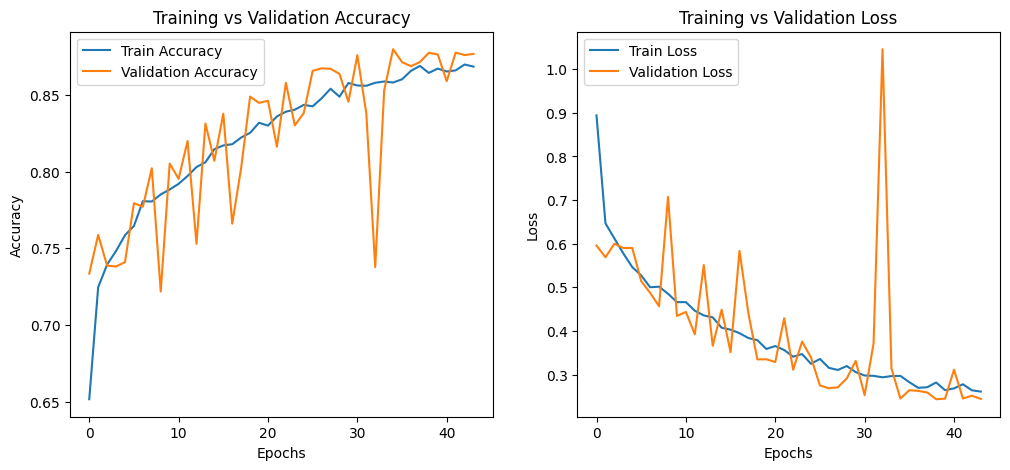

In [15]:
# Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

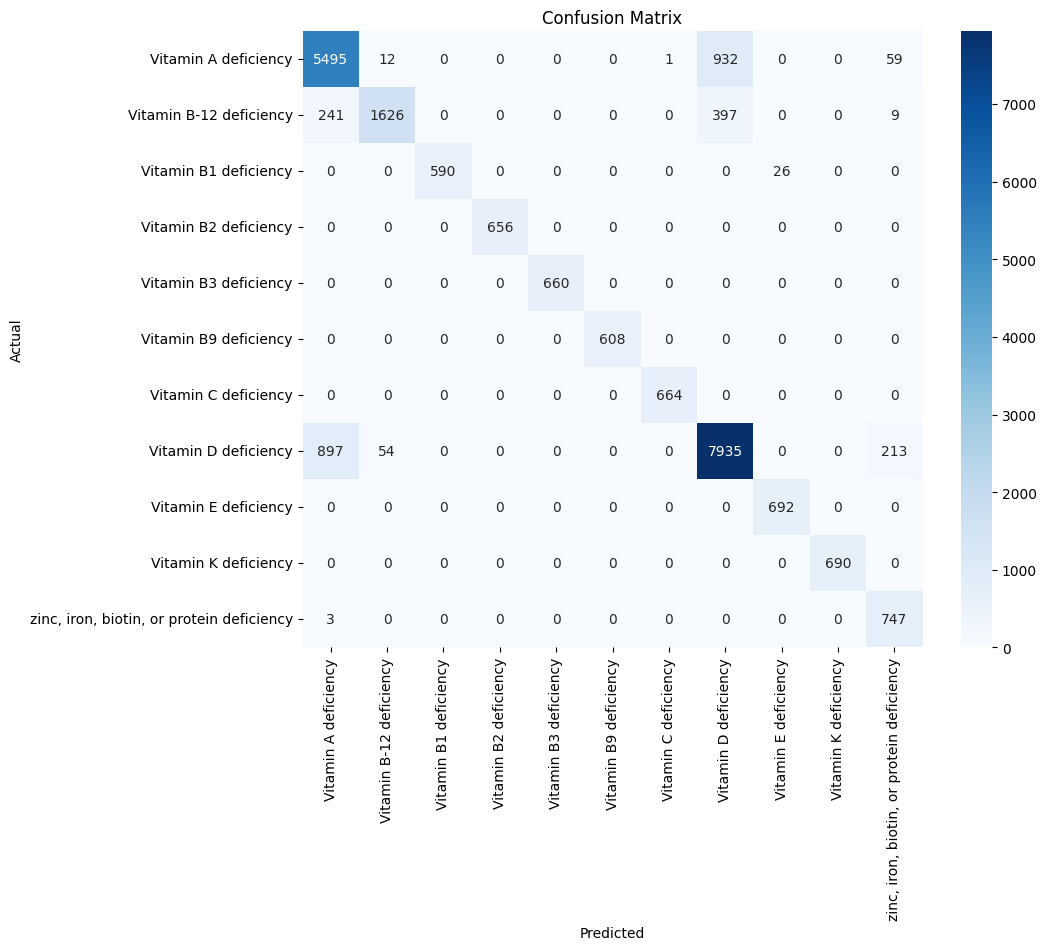

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predictions (raw output): [[9.9999988e-01 5.9081597e-08 1.2003376e-13 4.1257806e-15 1.5234008e-13
  8.2517391e-15 4.0240245e-11 1.5954132e-07 1.5540146e-11 2.9380968e-16
  1.8820164e-14]]


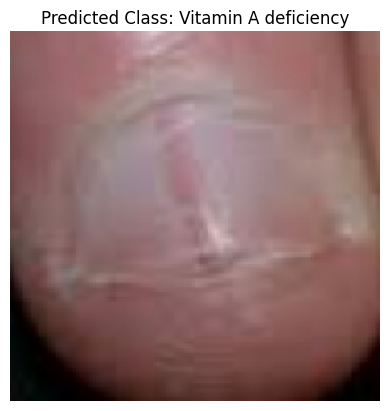

Predicted Class: Vitamin A deficiency


In [17]:
# Load the model
model = tf.keras.models.load_model("vitamin_deficiency_model.h5")

# Load class indices (if needed)
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)
classes = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Function to test a single image
def test_single_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make prediction
    predictions = model.predict(img_array)

    # Debugging: Print the predictions
    print(f"Predictions (raw output): {predictions}")

    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class = classes[predicted_class_idx]

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"Predicted Class: {predicted_class}")

# Example: Test a single image
test_single_image("/kaggle/input/vitamin-defficiency-dataset/dataset/Vitamin A deficiency/1.PNG")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predictions (raw output): [[5.9725735e-06 1.3487276e-08 9.9967206e-01 7.6885054e-11 8.6017032e-08
  1.0222102e-07 1.7403005e-08 6.7121732e-08 3.2162460e-04 6.3521433e-09
  1.1857230e-08]]


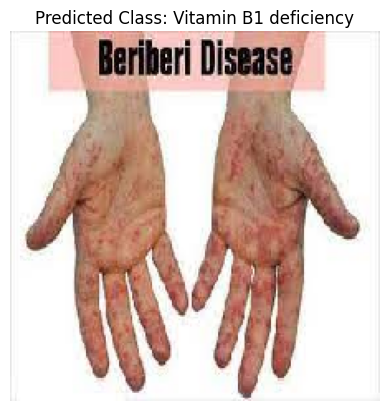

Predicted Class: Vitamin B1 deficiency


In [18]:
# Load the model
model = tf.keras.models.load_model("vitamin_deficiency_model.h5")

# Load class indices (if needed)
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)
classes = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Function to test a single image
def test_single_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make prediction
    predictions = model.predict(img_array)

    # Debugging: Print the predictions
    print(f"Predictions (raw output): {predictions}")

    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class = classes[predicted_class_idx]

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"Predicted Class: {predicted_class}")

# Example: Test a single image
test_single_image("/kaggle/input/vitamin-defficiency-dataset/dataset/Vitamin B1 deficiency/beriberi (1).jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predictions (raw output): [[3.8383483e-17 5.1622034e-18 3.6288870e-21 1.0000000e+00 1.4709950e-18
  2.5422914e-18 2.1548038e-16 2.6239458e-16 3.0067303e-22 1.5503870e-20
  2.8356493e-22]]


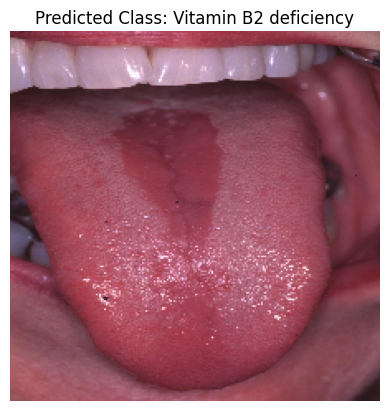

Predicted Class: Vitamin B2 deficiency


In [19]:
# Load the model
model = tf.keras.models.load_model("vitamin_deficiency_model.h5")

# Load class indices (if needed)
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)
classes = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Function to test a single image
def test_single_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make prediction
    predictions = model.predict(img_array)

    # Debugging: Print the predictions
    print(f"Predictions (raw output): {predictions}")

    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class = classes[predicted_class_idx]

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"Predicted Class: {predicted_class}")

# Example: Test a single image
test_single_image("/kaggle/input/vitamin-defficiency-dataset/dataset/Vitamin B2 deficiency/glossitis (1).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predictions (raw output): [[4.7577909e-16 2.1534036e-19 1.5391930e-13 4.5651970e-18 1.0000000e+00
  3.0855010e-20 9.0334840e-17 7.8857121e-14 2.5021895e-18 2.2517353e-18
  1.5873955e-20]]


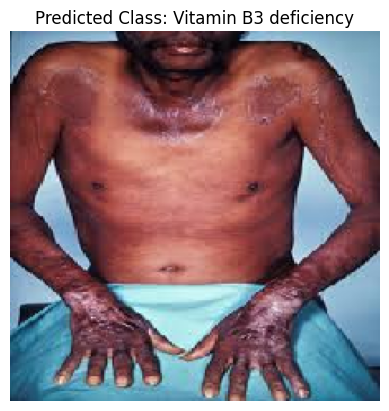

Predicted Class: Vitamin B3 deficiency


In [20]:
# Load the model
model = tf.keras.models.load_model("vitamin_deficiency_model.h5")

# Load class indices (if needed)
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)
classes = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Function to test a single image
def test_single_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make prediction
    predictions = model.predict(img_array)

    # Debugging: Print the predictions
    print(f"Predictions (raw output): {predictions}")

    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class = classes[predicted_class_idx]

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"Predicted Class: {predicted_class}")

# Example: Test a single image
test_single_image("/kaggle/input/vitamin-defficiency-dataset/dataset/Vitamin B3 deficiency/pellagra (1).jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predictions (raw output): [[1.0291799e-16 1.9156140e-18 2.1076258e-14 1.2824003e-15 2.5221524e-17
  1.0000000e+00 2.9012210e-16 4.3690620e-15 5.8432100e-14 1.3024547e-17
  3.3806677e-18]]


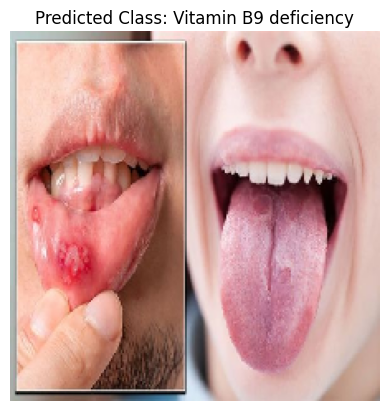

Predicted Class: Vitamin B9 deficiency


In [21]:
# Load the model
model = tf.keras.models.load_model("vitamin_deficiency_model.h5")

# Load class indices (if needed)
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)
classes = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Function to test a single image
def test_single_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make prediction
    predictions = model.predict(img_array)

    # Debugging: Print the predictions
    print(f"Predictions (raw output): {predictions}")

    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class = classes[predicted_class_idx]

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"Predicted Class: {predicted_class}")

# Example: Test a single image
test_single_image("/kaggle/input/vitamin-defficiency-dataset/dataset/Vitamin B9 deficiency/folate defficient (1).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predictions (raw output): [[2.0140216e-02 8.9182758e-01 4.0032983e-06 1.2620288e-06 6.5932238e-07
  9.8475255e-08 9.0241747e-07 8.8019341e-02 2.3656635e-06 4.2965976e-07
  3.0800647e-06]]


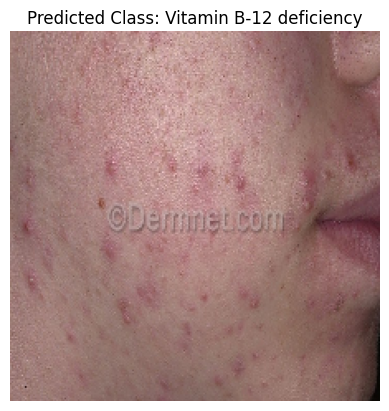

Predicted Class: Vitamin B-12 deficiency


In [22]:
# Load the model
model = tf.keras.models.load_model("vitamin_deficiency_model.h5")

# Load class indices (if needed)
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)
classes = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Function to test a single image
def test_single_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make prediction
    predictions = model.predict(img_array)

    # Debugging: Print the predictions
    print(f"Predictions (raw output): {predictions}")

    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class = classes[predicted_class_idx]

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"Predicted Class: {predicted_class}")

# Example: Test a single image
test_single_image("/kaggle/input/vitamin-defficiency-dataset/dataset/Vitamin B-12 deficiency/07Acne081101.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predictions (raw output): [[1.5555460e-07 9.7863162e-10 5.2767818e-11 4.9443161e-09 1.8598388e-09
  1.0318902e-08 9.9999952e-01 4.0873186e-07 3.8966794e-10 1.6156201e-11
  1.3221628e-09]]


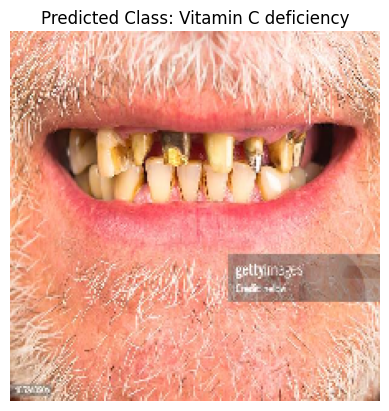

Predicted Class: Vitamin C deficiency


In [23]:
# Load the model
model = tf.keras.models.load_model("vitamin_deficiency_model.h5")

# Load class indices (if needed)
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)
classes = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Function to test a single image
def test_single_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make prediction
    predictions = model.predict(img_array)

    # Debugging: Print the predictions
    print(f"Predictions (raw output): {predictions}")

    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class = classes[predicted_class_idx]

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"Predicted Class: {predicted_class}")

# Example: Test a single image
test_single_image("/kaggle/input/vitamin-defficiency-dataset/dataset/Vitamin C deficiency/Scurvy (1).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predictions (raw output): [[1.3835689e-03 9.1386149e-03 1.0823142e-09 1.5952738e-08 1.2758307e-08
  1.2165577e-10 3.9106411e-08 9.8937267e-01 1.1962499e-09 1.0580252e-09
  1.0509302e-04]]


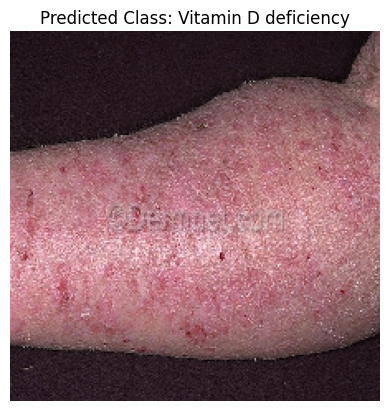

Predicted Class: Vitamin D deficiency


In [24]:
# Load the model
model = tf.keras.models.load_model("vitamin_deficiency_model.h5")

# Load class indices (if needed)
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)
classes = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Function to test a single image
def test_single_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make prediction
    predictions = model.predict(img_array)

    # Debugging: Print the predictions
    print(f"Predictions (raw output): {predictions}")

    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class = classes[predicted_class_idx]

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"Predicted Class: {predicted_class}")

# Example: Test a single image
test_single_image("/kaggle/input/vitamin-defficiency-dataset/dataset/Vitamin D deficiency/03DermatitisArm.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predictions (raw output): [[5.5615791e-21 9.8573307e-23 9.8669161e-17 4.3683961e-22 1.0241091e-22
  3.1422397e-22 3.0518542e-15 1.9962993e-16 1.0000000e+00 4.9452778e-25
  1.2986299e-24]]


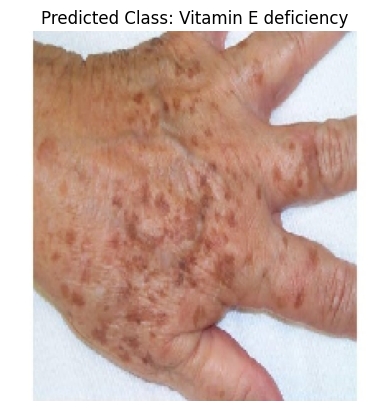

Predicted Class: Vitamin E deficiency


In [25]:
# Load the model
model = tf.keras.models.load_model("vitamin_deficiency_model.h5")

# Load class indices (if needed)
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)
classes = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Function to test a single image
def test_single_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make prediction
    predictions = model.predict(img_array)

    # Debugging: Print the predictions
    print(f"Predictions (raw output): {predictions}")

    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class = classes[predicted_class_idx]

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"Predicted Class: {predicted_class}")

# Example: Test a single image
test_single_image("/kaggle/input/vitamin-defficiency-dataset/dataset/Vitamin E deficiency/E Defficient (1).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predictions (raw output): [[7.6132602e-16 7.1563185e-28 4.6042793e-28 8.6731081e-33 8.2013278e-33
  8.5875417e-26 1.7427334e-29 4.3153536e-26 6.2227585e-29 1.0000000e+00
  6.5274177e-29]]


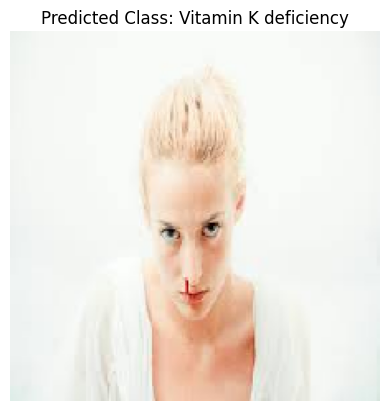

Predicted Class: Vitamin K deficiency


In [26]:
# Load the model
model = tf.keras.models.load_model("vitamin_deficiency_model.h5")

# Load class indices (if needed)
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)
classes = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Function to test a single image
def test_single_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make prediction
    predictions = model.predict(img_array)

    # Debugging: Print the predictions
    print(f"Predictions (raw output): {predictions}")

    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class = classes[predicted_class_idx]

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"Predicted Class: {predicted_class}")

# Example: Test a single image
test_single_image("/kaggle/input/vitamin-defficiency-dataset/dataset/Vitamin K deficiency/Blood cloth (1).jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predictions (raw output): [[9.9999738e-01 5.7610680e-07 6.5967766e-14 3.2889324e-14 1.4893116e-13
  1.8920825e-14 9.2795467e-12 2.0207378e-06 1.3210319e-11 2.3343585e-16
  1.3518911e-13]]


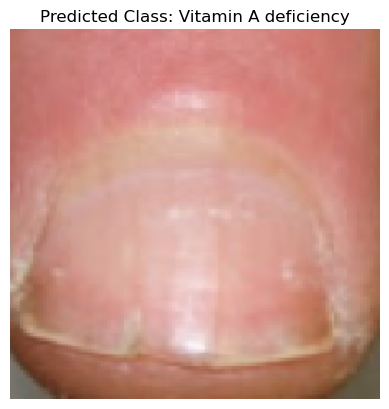

Predicted Class: Vitamin A deficiency


In [6]:
# Load the model
model = tf.keras.models.load_model("vitamin_deficiency_model.h5")

# Load class indices (if needed)
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)
classes = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Function to test a single image
def test_single_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make prediction
    predictions = model.predict(img_array)

    # Debugging: Print the predictions
    print(f"Predictions (raw output): {predictions}")

    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class = classes[predicted_class_idx]

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"Predicted Class: {predicted_class}")

# Example: Test a single image
test_single_image(r"C:\vitamin_project\dataset\vitamin_project_dataset\Vitamin A deficiency\12.PNG")

In [2]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import json

# Load the trained model
model = tf.keras.models.load_model("vitamin_deficiency_model.h5")

# Load class indices and reverse the mapping
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)
classes = {v: k for k, v in class_indices.items()}

# Set image size (same as model input)
img_size = 224

# Function to preprocess frame for prediction
def preprocess_frame(frame):
    img = cv2.resize(frame, (img_size, img_size))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img

# Start webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Cannot access webcam")
    exit()

print("Press 'q' to quit...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess and predict
    processed = preprocess_frame(frame)
    predictions = model.predict(processed)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_class = classes[predicted_class_idx]
    confidence = np.max(predictions) * 100

    # Display prediction on frame
    label = f"{predicted_class} ({confidence:.2f}%)"
    cv2.putText(frame, label, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Show the frame
    cv2.imshow("Vitamin Deficiency Detection", frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


Press 'q' to quit...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━

📸 Press 'SPACE' to capture an image and show prediction
❌ Press 'q' to quit
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


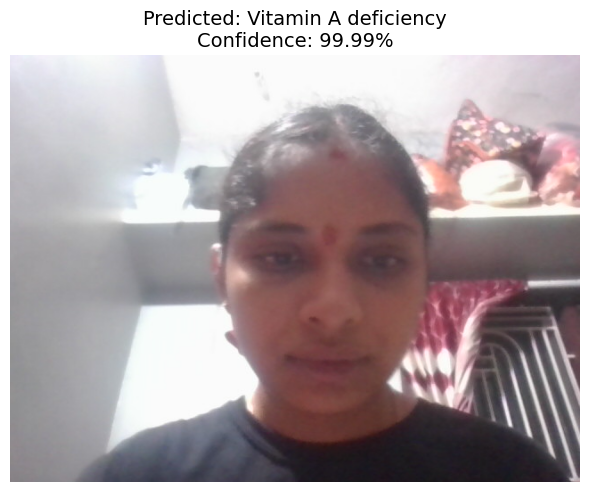

✅ Predicted Class: Vitamin A deficiency | Confidence: 99.99%


In [4]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import json

# Load the model
model = tf.keras.models.load_model("vitamin_deficiency_model.h5")

# Load class indices
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)
classes = {v: k for k, v in class_indices.items()}

# Image size
img_size = 224

# Preprocess image
def preprocess_frame(frame):
    img = cv2.resize(frame, (img_size, img_size))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img

# Start webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Cannot access webcam")
    exit()

print("📸 Press 'SPACE' to capture an image and show prediction")
print("❌ Press 'q' to quit")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow("Live Webcam Feed - Press SPACE to Capture", frame)

    key = cv2.waitKey(1) & 0xFF

    if key == ord(' '):  # SPACE to capture
        captured_img = frame.copy()
        processed = preprocess_frame(captured_img)

        # Predict
        predictions = model.predict(processed)
        predicted_class_idx = np.argmax(predictions, axis=1)[0]
        predicted_class = classes[predicted_class_idx]
        confidence = np.max(predictions) * 100

        # Convert BGR to RGB for displaying using matplotlib
        rgb_img = cv2.cvtColor(captured_img, cv2.COLOR_BGR2RGB)

        # Plot using matplotlib
        plt.figure(figsize=(6, 6))
        plt.imshow(rgb_img)
        plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        print(f"✅ Predicted Class: {predicted_class} | Confidence: {confidence:.2f}%")

    elif key == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()
